# P&D ISSP 2023 - Base notebook
@Students: Edit everything you want!

Packages

In [31]:
import matplotlib
import matplotlib.pyplot as plt
import scipy

import soundfile
import os
import package.general as genfcns
import package.gui_utils as guifcns
matplotlib.style.use('default')  # <-- for notebooks: white figures background

# Root path (path to where you are storing this very notebook)
#  /!/  Adapt this to your system  /!/ 
ROOTPATH = 'C:\devWorks\PnD\Signal_Processing_Project'

pathToSoundFiles = f'{ROOTPATH}/sound_files/'

# Parameters
speechfilenames = [
    pathToSoundFiles + 'speech1.wav',
    pathToSoundFiles + 'speech2.wav'
]
noisefilenames = [
    pathToSoundFiles + 'Babble_noise1.wav'
]
signalDuration = 10     # [s]
muGSC = 0.1     # NLMS update constant for freq.-domain GSC

# Soundfile names

In [7]:

soundfiles = {
    

'speech1':              pathToSoundFiles + 'speech1.wav',
'speech2':              pathToSoundFiles + 'speech2.wav',
'part1_track1_dry':     pathToSoundFiles + 'part1_track1_dry.wav',
'part1_track2_dry':     pathToSoundFiles + 'part1_track2_dry.wav',
'Babble_noise1':        pathToSoundFiles + 'Babble_noise1.wav',
'whitenoise_signal_1':  pathToSoundFiles + 'whitenoise_signal_1.wav',
'whitenoise_signal_2':  pathToSoundFiles + 'whitenoise_signal_2.wav'

}

Build acoustic scenario and generate RIRs using GUI

In [8]:
def gui():# Launch GUI
    guifcns.RIRg_GUI(
        exportFolder=f'{os.getcwd()}/rirs',
        outputRIRplot=False,
        distBwMics=10,  # [cm]
        fs=44100,
        t60=0,
        theme='SystemDefault',
    )

In [9]:
gui()

RIRs selection

In [10]:
def build(RIR_FILE_NAME = "",visualise = 0): # Select RIRs to be used
    '''
    default:                       takes latest RIRFile
    
    (optional) RIR_FILE_NAME:      name of rirfile with ".pkl.gz"

    (optional) visualise:           plots the acoustic scenario

    returns:                       acousticScenario   
    '''
    # RIR_FILE = 'rirs/'  # use this to input a specific set of RIRs (full path to .pkl.gz file)
    if RIR_FILE_NAME == "":
        RIR_FILE = genfcns.select_latest_rir(path='./rirs/')  # use this to select the lastly generated RIRs
        acousticScenario = guifcns.load_rirs(path=RIR_FILE)
    else:
        acousticScenario = guifcns.load_rirs(path= './rirs/' + str(RIR_FILE_NAME))
 
    # Load from Pickle archive
    
    # Show to user
    if visualise:
        acousticScenario.plot_asc()
        plt.show()    
    return acousticScenario

In [11]:
gui()

In [12]:
# ... Up to you, now!
acousticScenario = build("rirs_1.pkl.gz")
roomDim = acousticScenario.roomDim # access the room dimension [m]
print(acousticScenario) # print out all parameters


Acoustic scenario object containing the RIRs, with parameters:
>> Field "audioCoords": [[1.625, 4.050000000000001]]
>> Field "audioIds": ['25']
>> Field "c": 340
>> Field "distBwMics": 0.1
>> Field "exportFolder": c:\devWorks\PnD\Signal_Processing_Project/rirs
>> Field "fs": 44100
>> Field "lineIds": [1, 3, 4, 6, 8, 10, 12, 14, 16, 18]
>> Field "lineTextIds": [2, 5, 7, 9, 11, 13, 15, 17, 19]
>> Field "micsCoords": [[3.125, 2.9499999999999997], [3.125, 3.05], [3.125, 3.15], [3.125, 3.25], [3.125, 3.35]]
>> Field "micsIds": ['20', '21', '22', '23', '24']
>> Field "nMicsPerArray": 5
>> Field "noiseCoords": [[1.6500000000000001, 1.6500000000000001]]
>> Field "noiseIds": ['26']
>> Field "numMics": 5
>> Field "rirLength": 22050
>> Field "roomDim": 5.0
>> Field "t60": 0.0
>> Field "theme": SystemDefault



In [13]:
gui()

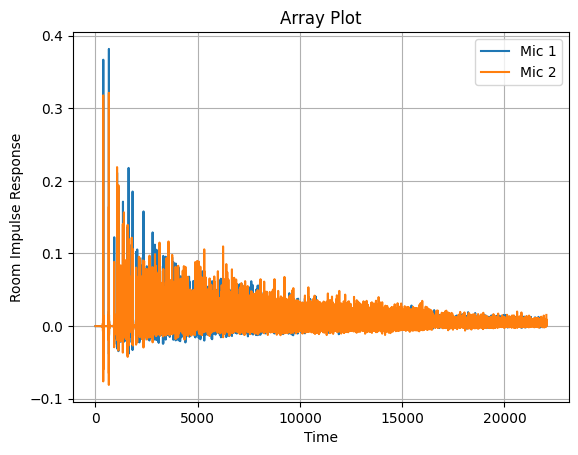

In [14]:
# Plot the array
#gui()
acousticScenario = build("rirs_1_4.pkl.gz")
plt.plot(acousticScenario.RIRsAudio[:,0,0])
plt.plot(acousticScenario.RIRsAudio[:,1,0])
# Labels and title
plt.xlabel('Time')
plt.legend(['Mic 1', 'Mic 2'])
plt.ylabel('Room Impulse Response')
plt.title('Array Plot')
#plt.xlim([165, 185])
plt.grid()
# Show the plot
plt.show()


part1_10

In [15]:
acousticScenario.RIRsAudio.shape

(22050, 3, 1)

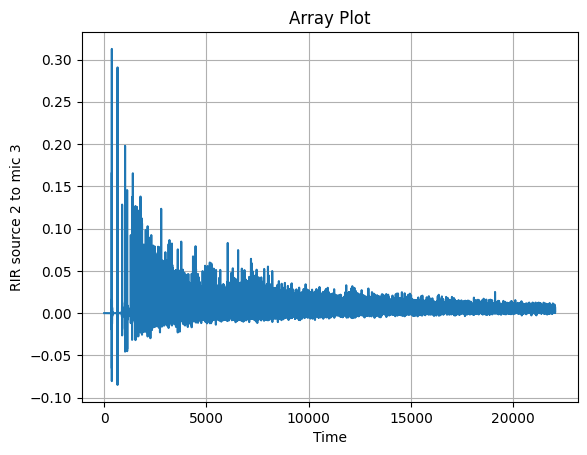

In [16]:
acousticScenario = build("rirs_4_10.pkl.gz")
plt.plot(acousticScenario.RIRsAudio[:,2,1])
# Labels and title
plt.xlabel('Time')
plt.ylabel('RIR source 2 to mic 3')
plt.title('Array Plot')
#plt.xlim([165, 185])
plt.grid()
# Show the plot
plt.show()

# Create_micsigs

In [17]:
import scipy.io.wavfile as wav
#import librosa
#import librosa.display
import numpy as np
from scipy.signal import fftconvolve,resample,correlate
def create_micsigs(acousticScenario, audio_src, noise_src = "",visualise=0):
    '''
    returns microphone signals, only audio, only noise
    
    acousticScenario: 

    audio_src:                  list of audio sources
    
    (optional) noise_src:       list of noise sources
    
    (optional) visualise:       visualises plots of microphone signals 

    
    '''
    start_time = 0  # seconds
    end_time = 10    # seconds
    sample_rate_audio = []
    sample_rate_noise = []
    processed_audio = []
    processed_noise = []
    for i in range(0,acousticScenario.RIRsAudio.shape[2]):
        sample_rate_audio, audio = wav.read(audio_src[i])
        start_sample_audio = int(start_time * sample_rate_audio)
        end_sample_audio = int(end_time * sample_rate_audio)

        audio = audio[start_sample_audio:end_sample_audio]

        num_samples = int(len(audio)* acousticScenario.fs/sample_rate_audio)
        unnorm_audio =resample(audio,num_samples)
        processed_audio.append(unnorm_audio / np.max(np.abs(unnorm_audio)))
    if acousticScenario.RIRsNoise is None:
        pass
    else:
        for i in range(0,acousticScenario.RIRsNoise.shape[2]):
            sample_rate_noise, noise = wav.read(noise_src[i])
            start_sample_noise = int(start_time * sample_rate_noise)
            end_sample_noise = int(end_time * sample_rate_noise)

            noise = noise[start_sample_noise:end_sample_noise]

            num_samples = int(len(noise)* acousticScenario.fs/sample_rate_noise)
            unnorm_noise =resample(noise,num_samples)
            processed_noise.append( unnorm_noise / np.max(np.abs(unnorm_noise)))



    mic = []
    for i in range (0,acousticScenario.RIRsAudio.shape[1]):
        mic_total = 0
        for j in range (0,acousticScenario.RIRsAudio.shape[2]):
            mic_audio = fftconvolve(processed_audio[j], acousticScenario.RIRsAudio[:,i,j], mode='full')
            mic_total = mic_total + mic_audio

        if acousticScenario.RIRsNoise is None:
            pass
        else:
            for j in range (0,acousticScenario.RIRsNoise.shape[2]):
                mic_noise = fftconvolve(processed_noise[j], acousticScenario.RIRsNoise[:,i,j], mode='full')
                mic_total = mic_total + mic_noise

        norm_mic = mic_total / np.max(np.abs(mic_total))
        mic.append(norm_mic)

    # Plot the array
    plt.plot(mic[0])
    plt.plot(mic[1])
    # Labels and title
    plt.xlabel('Time')
    plt.ylabel('Mic Signal')
    plt.title('Microphone 1 and 2')
    plt.grid()
    #plt.xlim([150, 180])
    # Show the plot
    plt.show()

    return mic, processed_audio, processed_noise


44100


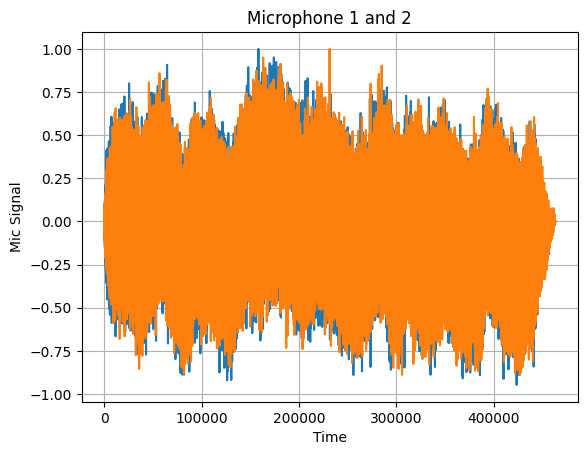

In [18]:
print(acousticScenario.fs)
speechfilenames = [
    pathToSoundFiles + 'speech1.wav',
    pathToSoundFiles + 'whitenoise_signal_1.wav'
]
noisefilenames = [
    pathToSoundFiles + 'whitenoise_signal_1.wav',
    pathToSoundFiles + 'whitenoise_signal_2.wav'
]


mict, aud, noise = create_micsigs(acousticScenario, speechfilenames, noisefilenames)
soundfile.write("output.wav", mict[0], acousticScenario.fs)

In [19]:
acousticScenario.RIRsAudio.shape

(22050, 3, 2)

In [20]:
Gnd_truth = -3+len(mict[0]) - 1

# TDOA_corr

In [21]:
def TDOA_corr(mict,acousticScenario=None,correlationPair=[0,1], n=1,correlationMicNum = 1, start = 0, stop = -1,zoom = 50):
    '''
    mict:                       array of 2 microphone signals to be correlated, used as mict[0] and mict[1]
    
    (optional) acousticScenario:    allows groundtruths to be plottted 
    
    (optional) correlationPair:     used for groundtruth. select indexes of mics on arrays ,default = [0,1]
    
    (optional)correlationMicNum: Index of mic (0 to #mics) to do the correlation with mic 0 (default = mic 1)            

    (optional) seglength:  length of segment for correlation (defaults to total RIR length)
    
    (optional) zoom:       how many samples around middle of correlation

    (optional) n:           amount of peaks to be detected with original method

    returns: TDOA_method1, TDOA_method2, Groundtruths   (in sample delays, use DOA_corr for angles)               

    '''
    # ground truths
    ground_truths = []
    ground_truths_pos= []
    if acousticScenario is None:
        pass
    else:
        numSources = len(acousticScenario.audioIds)
        for i in range(numSources): 
            ir1 = acousticScenario.RIRsAudio[:,correlationPair[0],i]
            ir2 = acousticScenario.RIRsAudio[:,correlationPair[1],i]
            #assume max value is direct path component  
            ground_truths.append(np.argmax(ir1) - np.argmax(ir2))
        if 0:
            a = min(np.argmax(ir1),np.argmax(ir2)) -5
            b = max(np.argmax(ir1),np.argmax(ir2)) +5
            plt.plot(np.arange(a,b),ir1[a:b])
            plt.plot(np.arange(a,b),ir2[a:b])
            plt.show()

            
        ground_truths.sort()
        
        #segLength, _,_ = acousticScenario.RIRsAudio.shape
        for i in range(len(ground_truths)):
            ground_truths_pos.append( ground_truths[i] + len(mict[0]) - 1)
    
    
    # Cross-correlation of the two microphone signals
    
    xcorr = correlate(mict[0], mict[1], mode='full')
    correlation = xcorr[:] #copy the list, use og copy for plotting
    #proposed method
    peaks =scipy.signal.find_peaks(xcorr,height= max(xcorr)*0.5,distance=1)
    peaks = peaks[0] #to get only peak positions
    oobPeaks = []
    sample_delays = []
    for i in range(len(peaks)):
        sample_delays.append(peaks[i]- len(mict[0]) +1 )
            
    sample_delays.sort()

    # Time delay of arrival
    TDOA_list = []
    #peaks1: usign original method
    peaks1 = []
    for i in range(n):
        peaks1.append(np.argmax(xcorr))
        TDOA_list.append( peaks1[i] - len(mict[0]) + 1)
        xcorr = np.delete(xcorr, np.argmax(xcorr))

    # Plot the cross-correlation
    
    if zoom > 0: #zoom
        a = int(len(xcorr)/2 - zoom)
        b= int(len(xcorr)/2 + zoom)

        plt.plot(np.arange(a,b),xcorr[a:b])
    else:
        plt.plot(correlation)
    if ground_truths_pos != []:
        plt.stem(ground_truths_pos,np.zeros(len(ground_truths_pos)),markerfmt="red") #plot groundtruth as red dot
    
    plt.stem(peaks1,np.ones(len(peaks1))*max(xcorr)*0.5,markerfmt="blue") #plot detected peaks as blue dots (OG method)
    print(peaks)
    plt.stem(peaks,np.ones(len(peaks))*max(xcorr)*-0.1,markerfmt="green") #plot detected peaks as green dots (proposed method)
    plt.xlabel('Time')
    plt.ylabel('Cross-correlation')
    plt.title('Cross-correlation of the two microphone signals')
    plt.grid()
    if stop !=-1:
        plt.xlim([start, stop])
    #plt.stem(Gnd_truth, xcorr[Gnd_truth], 'r')
    plt.show()
    sample_delays.sort()
    TDOA_list.sort()
    if ground_truths_pos != []:
        print("ground truth: "+str(ground_truths))
    print("proposed method: "+str(sample_delays))
    print("original method: "+str(TDOA_list))

    return TDOA_list,sample_delays,ground_truths #



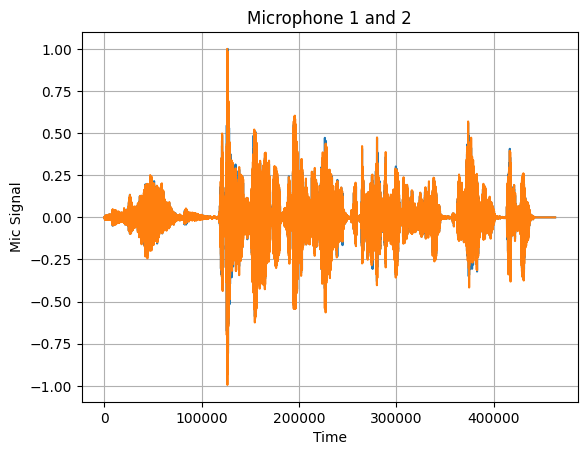

[463011 463084]


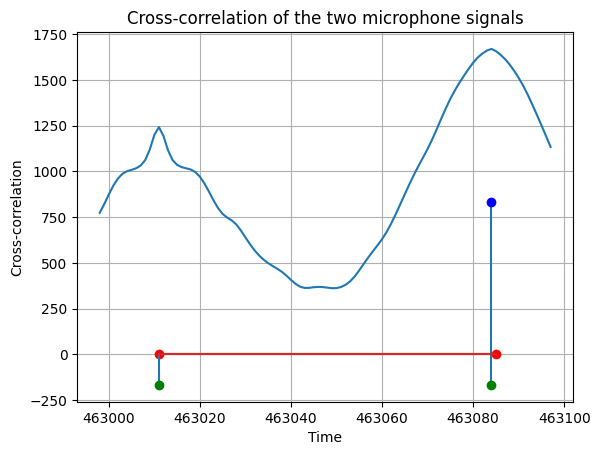

ground truth: [-37, 37]
proposed method: [-37, 36]
original method: [36]


In [22]:
#acousticScenario = build("rirs_2mics,1scrs.pkl.gz")
acousticScenario = build("rirs_5_1.pkl.gz")

#acousticScenario = build("rirs_4_10.pkl.gz")
micsigs,_,_ = create_micsigs(acousticScenario,[soundfiles["part1_track1_dry"],soundfiles["part1_track2_dry"]])
TDOA,sample_delays,ground_truth= TDOA_corr([micsigs[0],micsigs[4]],acousticScenario=acousticScenario,correlationPair=[0,4])
#print(TDOA[0]*180/np.pi)
#print(sample_delays[0]*180/np.pi)
#print(ground_truth[0]*180/np.pi)

In [23]:
gui()

In [24]:
acousticScenario = build("rirs_2mics,1scrs.pkl.gz")


# DOA_corr

In [25]:
def DOA_corr(TDOA,fs, d):
    '''
    TDOA: output from TDOA_corr()

    fs: sampling rate of signal used in TDOA_corr()

    d: distance between mics (use acousticScenario.distBwmics), check correctness if angles are out of bounds 
    '''
    DOAestAll = []
    #_,TDOA,_ = TDOA_corr(acousticScenario,speechfilenames,correlationMicNum=num)
    for i in range(0,len(TDOA)):
            
        # Speed of sound
        c = 340  # [m/s]
        # Distance between microphones
        # Time delay of arrival
        tau = TDOA[i]/fs
        # Angle of arrival
        #print(tau), print(d), print(c), print(np.arccos(c*tau/d))
        if c*tau/d >= 1:
            DOA =0
            print("warning: delay out of bounds (0°)")
        elif c*tau/d <= -1:
            DOA = np.pi
            print("warning: delay out of bounds(90°)")
        else:
            DOA = np.arccos(c*tau/d) #*180/np.pi
      
        doa  =np.arccos(TDOA[i]/fs*c/d)# *360/(2*math.pi)
        DOAestAll.append(doa)
    return DOAestAll

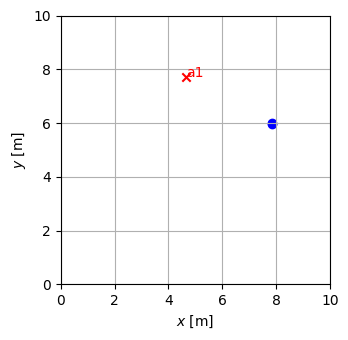

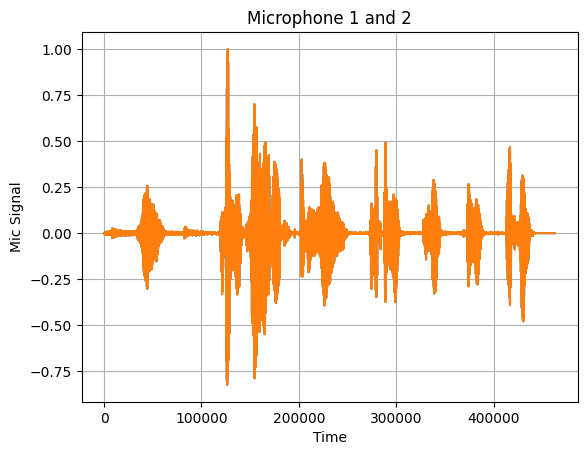

[463051]


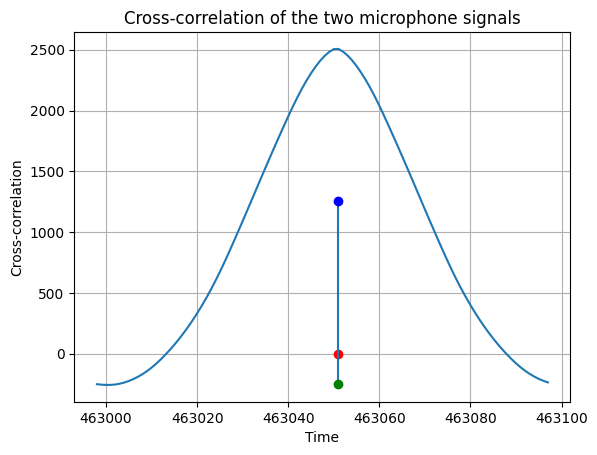

ground truth: [3]
proposed method: [3]
original method: [3]
62.44595877091582


In [26]:
acousticScenario = build("rirs_2mics,1scrs.pkl.gz",visualise=1)
micsigs,_,_ = create_micsigs(acousticScenario,[soundfiles["part1_track1_dry"],soundfiles["part1_track2_dry"]])
TDOA,sample_delays,ground_truth= TDOA_corr([micsigs[0],micsigs[1]],acousticScenario=acousticScenario,correlationPair=[0,1])
DOAestAll = DOA_corr(sample_delays,acousticScenario.fs,acousticScenario.distBwMics)
print(DOAestAll[0]*180/np.pi)

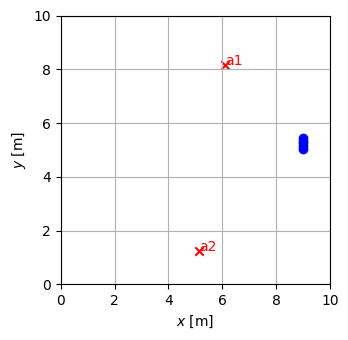

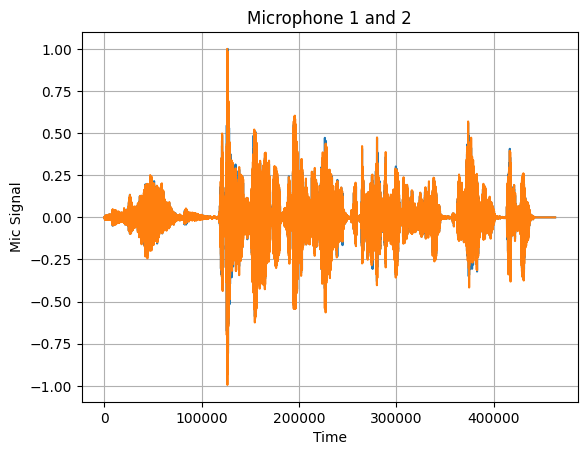

[463011 463084]


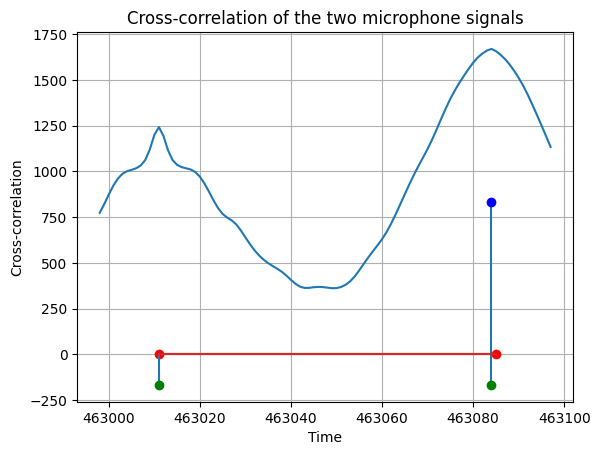

ground truth: [-37, 37]
proposed method: [-37, 36]
original method: [36]
Oracle-selected estimated DOAs: [135.49194692  46.06216011]
Target DOAs estimate error(s): [0.5 2.2] deg.


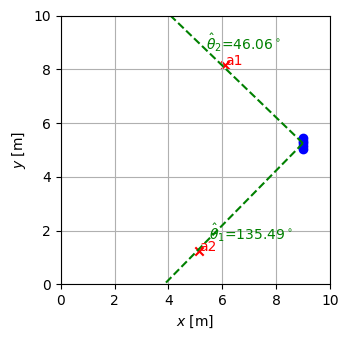

In [27]:


acousticScenario = build("rirs_5_1.pkl.gz",visualise=1)
micsigs,_,_ = create_micsigs(acousticScenario,[soundfiles["part1_track1_dry"],soundfiles["part1_track2_dry"]])
TDOA,sample_delays,ground_truth= TDOA_corr([micsigs[0],micsigs[4]],acousticScenario=acousticScenario,correlationPair=[0,4])
DOAestAll = DOA_corr(sample_delays,acousticScenario.fs,acousticScenario.distBwMics*4)

# Oracle selection of the target DOA
DOAest, oracleDOAtalkers = genfcns.oracle_choice_doa(
    DOAestAll, acousticScenario
)
print(f'Oracle-selected estimated DOAs: {DOAest * 180/np.pi}')
# Check validity
genfcns.check_plot_tdoas(DOAest, DOAestAll, acousticScenario)
print(f'Target DOAs estimate error(s): {np.round((DOAest - oracleDOAtalkers) * 180/np.pi, 1)} deg.')

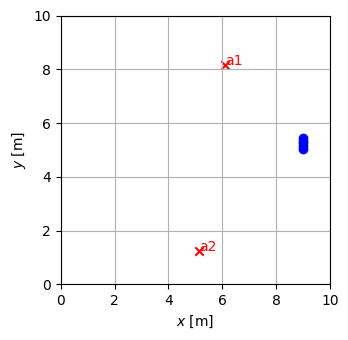

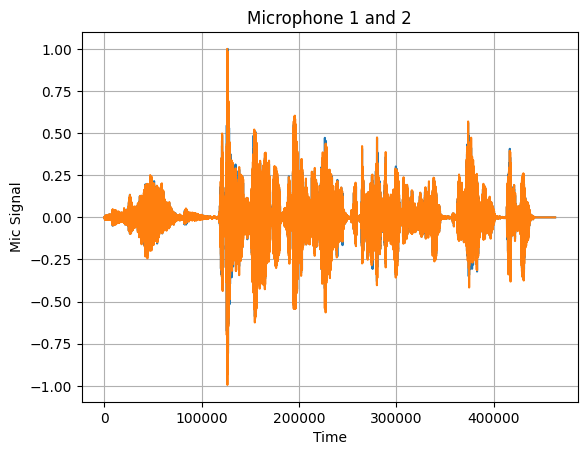

[463011 463084]


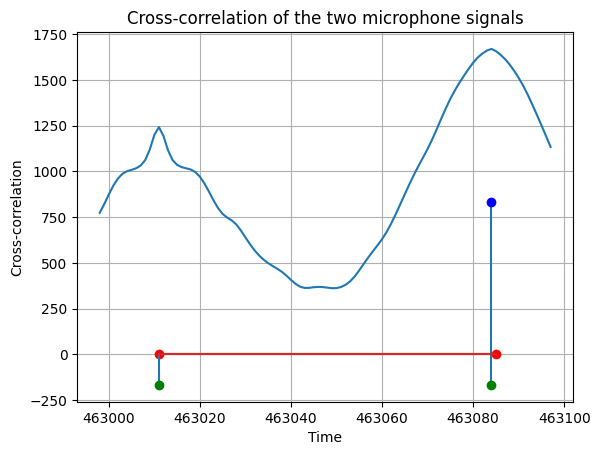

ground truth: [-37, 37]
proposed method: [-37, 36]
original method: [36]
[455212 455228 455327 ... 470524 470693 470726]


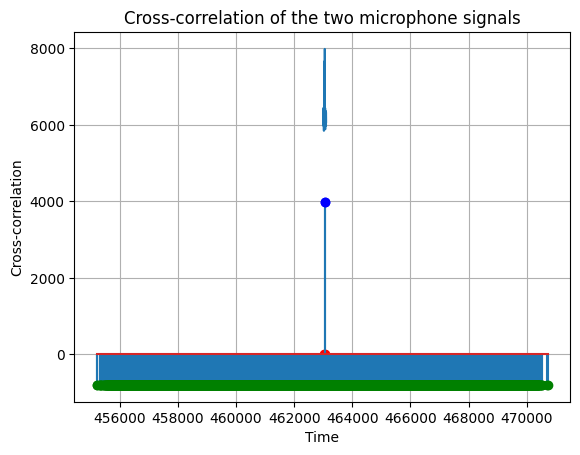

ground truth: [-9, 10]
proposed method: [-7836, -7820, -7721, -7718, -7714, -7702, -7648, -7643, -7592, -7585, -7573, -7548, -7536, -7523, -7510, -7507, -7479, -7475, -7468, -7464, -7456, -7453, -7430, -7419, -7414, -7400, -7387, -7379, -7352, -7343, -7339, -7336, -7327, -7310, -7308, -7302, -7298, -7294, -7292, -7290, -7286, -7279, -7277, -7275, -7271, -7265, -7261, -7254, -7248, -7245, -7243, -7241, -7238, -7235, -7231, -7228, -7221, -7217, -7214, -7210, -7202, -7199, -7197, -7193, -7191, -7185, -7181, -7175, -7170, -7167, -7161, -7158, -7154, -7150, -7147, -7145, -7143, -7139, -7135, -7133, -7130, -7128, -7125, -7116, -7114, -7112, -7110, -7105, -7103, -7100, -7097, -7094, -7087, -7082, -7079, -7074, -7072, -7070, -7067, -7063, -7059, -7057, -7053, -7051, -7047, -7044, -7042, -7040, -7037, -7034, -7031, -7028, -7025, -7022, -7019, -7016, -7014, -7010, -7007, -7005, -7000, -6996, -6992, -6990, -6987, -6985, -6982, -6978, -6974, -6972, -6970, -6964, -6962, -6958, -6953, -6951, -6949, 

TypeError: unsupported operand type(s) for /: 'list' and 'int'

In [29]:
from itertools import combinations

acousticScenario = build("rirs_5_1.pkl.gz",visualise=1)
micsigs,_,_ = create_micsigs(acousticScenario,[soundfiles["part1_track1_dry"],soundfiles["part1_track2_dry"]])
TDOA,sample_delays,ground_truth= TDOA_corr([micsigs[0],micsigs[4]],acousticScenario=acousticScenario,correlationPair=[0,4])
DOAestAll = DOA_corr(sample_delays,acousticScenario.fs,acousticScenario.distBwMics*4)

for mic1_num, mic2_num in combinations([x for x in range(0,len(mict))], 2):
    TDOA = TDOA_corr([mict[mic1_num], mict[mic2_num]],acousticScenario,correlationPair=[mic1_num,mic2_num], n=2)
    d = (mic2_num-mic1_num)*0.1
    DOAestAll = DOA_corr(TDOA, acousticScenario.fs, d)
    print(mic1_num, mic2_num)
    print(DOAestAll[0]*180/np.pi)
    print(DOAestAll[1]*180/np.pi)
    print(TDOA)

# create_micsigs_wav

In [ ]:
import scipy.io.wavfile as wav
#import librosa
#import librosa.display
import numpy as np
from scipy.signal import fftconvolve,resample,correlate
def create_micsigs_wav(MIRwavfiles, audio_src, noise_src):
    start_time = 2  # seconds
    end_time = 5    # seconds
    sample_rate_audio = []
    sample_rate_noise = []
    processed_audio = []
    processed_noise = []

    MIR_fs,MIR = wav.read(MIRwavfiles[0][0])
    for i in range(0,len(audio_src)):

        sample_rate_audio, audio = wav.read(audio_src[i])
        start_sample_audio = int(start_time * sample_rate_audio)
        end_sample_audio = int(end_time * sample_rate_audio)

        audio = audio[start_sample_audio:end_sample_audio]

        num_samples = int(len(audio)* MIR_fs/sample_rate_audio)
        unnorm_audio =resample(audio,num_samples)
        processed_audio.append(unnorm_audio / np.max(np.abs(unnorm_audio)))
    if len(noise_src) == 0:
        pass
    else:
        for i in range(0,len(noise_src)):
            sample_rate_noise, noise = wav.read(noise_src[i])
            start_sample_noise = int(start_time * sample_rate_noise)
            end_sample_noise = int(end_time * sample_rate_noise)

            noise = noise[start_sample_noise:end_sample_noise]

            num_samples = int(len(noise)* MIR_fs/sample_rate_noise)
            unnorm_noise =resample(noise,num_samples)
            processed_noise.append( unnorm_noise / np.max(np.abs(unnorm_noise)))



    mic = [0 for i in range(0,len(MIRwavfiles[0]))]
    for j in range (0,len(audio_src)):
        for i in range (0,len(MIRwavfiles[j])):
            #print(MIRwavfiles[j][i])
            MIR_fs,MIR = wav.read(MIRwavfiles[j][i])
            
            mic_audio = fftconvolve(processed_audio[j], MIR, mode='full')
            mic[i]= mic[i] + mic_audio
    for j in range (0,len(noise_src)):
        for i in range (0,len(MIRwavfiles[j])):
            MIR_fs,MIR = wav.read(MIRwavfiles[j][i])
            
            mic_noise = fftconvolve(processed_noise[j], MIR, mode='full')
            mic[i]= mic[i] + mic_noise
    norm_mic=  [mic[i] / np.max(np.abs(mic[i])) for i in range(0,len(mic))]

    """for j in range (0,len(audio_src)):
        mic_audio = fftconvolve(processed_audio[j], MIR, mode='full')
        mic_total = mic_total + mic_audio

    if acousticScenario.RIRsNoise is None:
        pass
    else:
        for j in range (0,len(noise_src)):
            mic_noise = fftconvolve(processed_noise[j], MIR, mode='full')
            mic_total = mic_total + mic_noise"""

            

    # Plot the array
    plt.plot(norm_mic[0])
    plt.plot(norm_mic[1])
    # Labels and title
    plt.xlabel('Time')
    plt.ylabel('Mic Signal')
    plt.title('Microphone 1 and 2')
    plt.grid()
    #plt.xlim([150, 180])
    # Show the plot
    plt.show()

    return norm_mic, processed_audio, processed_noise


44100


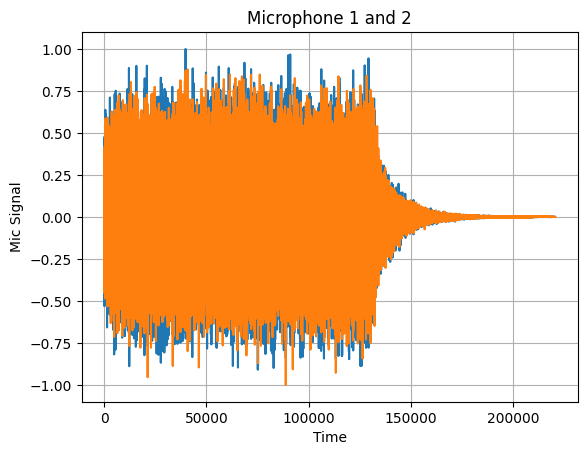

TypeError: TDOA_corr() missing 1 required positional argument: 'speechfilenames'

In [ ]:
print(acousticScenario.fs)
speechfilenames = [
    pathToSoundFiles + 'whitenoise_signal_2.wav',
    pathToSoundFiles + 'whitenoise_signal_2.wav'
]
noisefilenames = [

]

MIC_WAV = [
    [pathToSoundFiles+"head_mounted_rirs/s30/HMIR_L1.wav",
    pathToSoundFiles+"head_mounted_rirs/s30/HMIR_L2.wav",
    pathToSoundFiles+"head_mounted_rirs/s30/HMIR_R1.wav",
    pathToSoundFiles+"head_mounted_rirs/s30/HMIR_R2.wav"],
[pathToSoundFiles+"head_mounted_rirs/s-60/HMIR_L1.wav",
    pathToSoundFiles+"head_mounted_rirs/s-60/HMIR_L2.wav",
    pathToSoundFiles+"head_mounted_rirs/s-60/HMIR_R1.wav",
    pathToSoundFiles+"head_mounted_rirs/s-60/HMIR_R2.wav"]]


mict, aud, noise = create_micsigs_wav(MIC_WAV, speechfilenames, noisefilenames)
soundfile.write("output.wav", mict[0], acousticScenario.fs)

from itertools import combinations
"""for mic1_num, mic2_num in combinations([x for x in range(0,len(mict))], 2):
    TDOA = TDOA_corr(mict[mic1_num], mict[mic2_num], n=2)
    d = (mic2_num-mic1_num)*0.1
    DOAestAll = DOA_corr(TDOA, acousticScenario.fs, d)
    print(mic1_num, mic2_num)
    print(DOAestAll[0]*180/np.pi)
    print(DOAestAll[1]*180/np.pi)
    print(TDOA)"""
MIR_fs,MIR = wav.read(MIC_WAV[0][0])
#TDOA = TDOA_corr(acousticScenario, n=2)
#d = 0.013
#DOAestAll = DOA_corr(TDOA,MIR_fs , d)
DOAestAll = DOA_corr(TDOA,MIR_fs , d)
print("L1, L2")
print(DOAestAll[0]*180/np.pi)
print(DOAestAll[1]*180/np.pi)


TDOA = TDOA_corr(mict[2], mict[3], n=2)
d = 0.013
DOAestAll = DOA_corr(TDOA, MIR_fs, d)
print("R1, R2")
print(DOAestAll[0]*180/np.pi)
print(DOAestAll[1]*180/np.pi)

TDOA = TDOA_corr(acousticScenario n=2)
d = 0.215
DOAestAll = DOA_corr(TDOA, acousticScenario.fs, d)
print("L1, R1")
print(DOAestAll[0]*180/np.pi)
print(DOAestAll[1]*180/np.pi)



TESTING WEEK 1

44100


TypeError: 'RIRg_GUI' object is not subscriptable

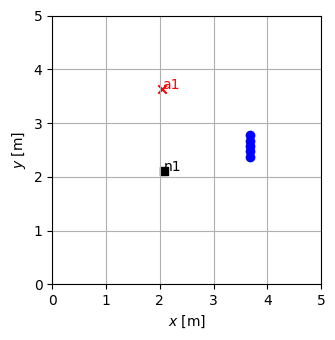

In [ ]:
gui()
acousticScenario = build()

print(acousticScenario.fs)
speechfilenames = [
    pathToSoundFiles + 'whitenoise_signal_1.wav',
    pathToSoundFiles + 'whitenoise_signal_2.wav'
]
noisefilenames = [
]


mict, aud, noise = create_micsigs(acousticScenario, speechfilenames, noisefilenames)
soundfile.write("output.wav", mict[0], acousticScenario.fs)
TDOA = TDOA_corr(mict[0], mict[1], n=2, start = 463000, stop = 463100)
d = 0.1
DOAestAll = DOA_corr(TDOA, acousticScenario.fs, d)
#print("L1, R1")
print(DOAestAll[0]*180/np.pi)
print(DOAestAll[1]*180/np.pi)

# Signal processing - Week 2: MUSIC algorithm

In [ ]:
import numpy as np

winLength = 1024 # Window length
nSources = acousticScenario.RIRsAudio.shape[-1] +\
    acousticScenario.RIRsNoise.shape[-1] # Number of sources
theta = np.arange(0, np.pi, step=np.pi / 360)  # angles to consider

print('Computing DOAs via freq.-domain MUSIC algorithm...')


# DOAestAll = yourMUSIC() ...
DOAestAll = np.zeros(nSources)  # default


print(f'All estimated DOAs: {DOAestAll * 180/np.pi}')

# ------------------ DOA estimation performance check ------------------
# Oracle selection of the target DOA
DOAest, oracleDOAtalkers = genfcns.oracle_choice_doa(
    DOAestAll, acousticScenario
)
print(f'Oracle-selected estimated DOAs: {DOAest * 180/np.pi}')
# Check validity
genfcns.check_plot_tdoas(DOAest, DOAestAll, acousticScenario)
print(f'Target DOAs estimate error(s): {np.round((DOAest - oracleDOAtalkers) * 180/np.pi, 1)} deg.')

AttributeError: 'NoneType' object has no attribute 'shape'

Note that the RIRs are sampled at 44100 Hz.
PyRoomAcoustics is computing the 8 RIRs...
RIRs computed successfully. Saving as Pickle archive.
RIRs saved in file: "rirs_20250218_14h58m05s.pkl.gz", in folder
"c:\devWorks\PnD\Signal_Processing_Project\rirs"


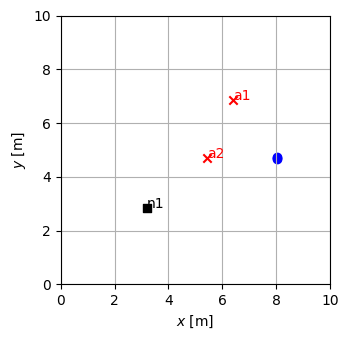

In [ ]:
gui()
acousticScenario = build()


44100


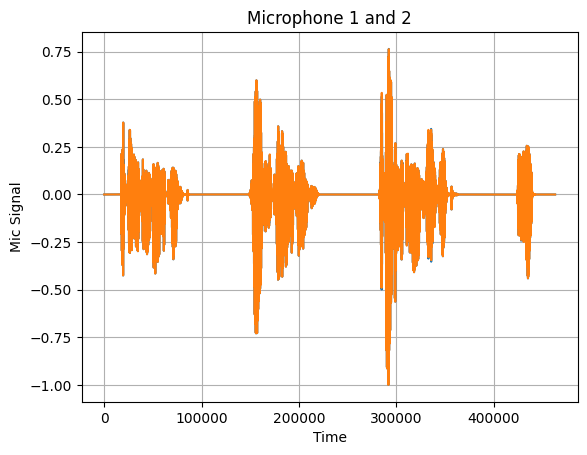

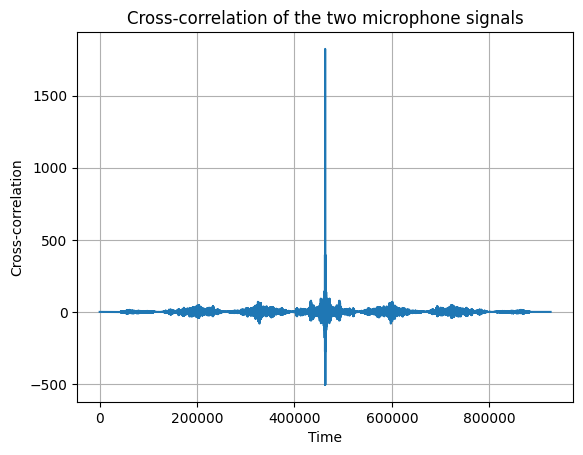

128.08137571806267


In [ ]:

print(acousticScenario.fs)
speechfilenames = [
    pathToSoundFiles + 'speech1.wav'
]
noisefilenames = [
]


mict, aud, noise = create_micsigs(acousticScenario, speechfilenames, noisefilenames)
soundfile.write("output.wav", mict[0], acousticScenario.fs)
TDOA = TDOA_corr(mict[0], mict[1], n=1, start = 0, stop = -1)
d = 0.05
DOAestAll = DOA_corr(TDOA, acousticScenario.fs, d)
#print("L1, R1")
print(DOAestAll[0]*180/np.pi)
#print(DOAestAll[1]*180/np.pi)

In [ ]:
from scipy.signal import stft
if acousticScenario.fs == 44100:
    ShortTimeFourierTransform = []
    for mic in mict:
        f, t, Zxx = stft(mic, fs=acousticScenario.fs, nperseg=1024, noverlap=512)
        ShortTimeFourierTransform.append(Zxx)
    ShortTimeFourierTransform = np.array(ShortTimeFourierTransform)
    """plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
    plt.title('STFT Magnitude')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()"""
else:
    print('STFT not available for this sampling frequency.')

In [ ]:
print(len(ShortTimeFourierTransform))
print(ShortTimeFourierTransform[0].shape)

5
(513, 906)


In [ ]:
def music_narrowband(ShortTimeFourierTransform, f):
    # Compute average power per frequency bin across microphones and time frames
    avg_power = None
    for Z in ShortTimeFourierTransform:
        # For each microphone: compute the power (squared magnitude) and average over time frames (axis=1)
        power_per_freq = np.mean(np.abs(Z)**2, axis=1)
        if avg_power is None:
            avg_power = power_per_freq
        else:
            avg_power += power_per_freq
    avg_power /= len(ShortTimeFourierTransform)

    # Use the frequency vector 'f' to select the frequency bin with highest average power
    idx_max = np.argmax(avg_power)
    omega_max = f[idx_max]
    print("Frequency bin with highest power:", omega_max)
    

    nSources = len(ShortTimeFourierTransform)
    # Compute the covariance matrix of the observed signals
    R = np.zeros((nSources, nSources), dtype=complex)
    for i in range(0,ShortTimeFourierTransform[0].shape[0]):
        # For each time frame: compute the cross-spectral density matrix
        R += np.outer(ShortTimeFourierTransform[:,i,idx_max], np.conj(ShortTimeFourierTransform[:,i,idx_max]))
    R /= len(ShortTimeFourierTransform)

    # Define theta range
    theta = np.arange(0, np.pi, step=np.pi / 360)
     

    # Compute the MUSIC pseudospectrum
    _, V = np.linalg.eigh(R)
    P = np.zeros(len(theta))
    for i, th in enumerate(theta):
        a = np.exp(1j * np.arange(nSources) * 2 * np.pi * np.sin(th))
        P[i] = 1 / np.abs(a.conj().T @ V[:, :-nSources] @ V[:, :-nSources].conj().T @ a)


    plt.plot(theta, 10 * np.log10(P / np.max(P)))
    plt.title('Pseudospectrum')
    plt.ylabel('P_theta [dB]')
    plt.xlabel('theta [rad]')
    plt.show()
    return P
    

Frequency bin with highest power: 215.33203125


C:\Users\vande\AppData\Local\Temp\ipykernel_12060\471021742.py:36: RuntimeWarning: divide by zero encountered in scalar divide
  P[i] = 1 / np.abs(a.conj().T @ V[:, :-nSources] @ V[:, :-nSources].conj().T @ a)
C:\Users\vande\AppData\Local\Temp\ipykernel_12060\471021742.py:39: RuntimeWarning: invalid value encountered in divide
  plt.plot(theta, 10 * np.log10(P / np.max(P)))


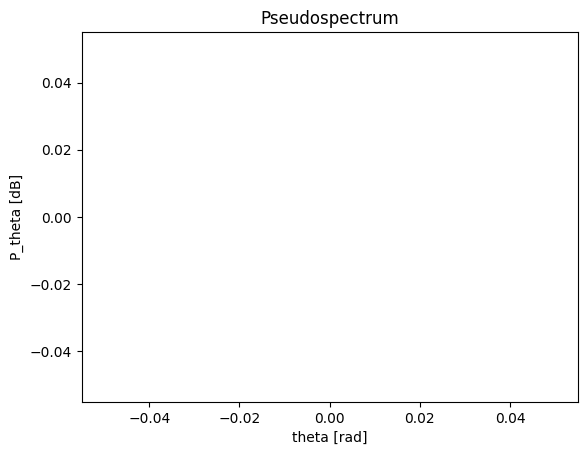

In [ ]:
P = music_narrowband(ShortTimeFourierTransform, f)
